In [260]:
using BioTools, BioSequences
using Plots, StatsPlots
using TreeTools
using StatsBase, Dates, Measures
using Random, Statistics, DelimitedFiles
using LaTeXStrings
include("../functions/plot_functions.jl")

pfix_v_freq_positivederivative (generic function with 1 method)

In [92]:
pyplot()
plot(rand(10),size=(1,1))

In [93]:
lfs = 22 # Legend font size
alfs = 26 # axis label font size
tfs = 22 # title font size
atfs = 22 # axis ticks font size
ga = 0.3 # grid alpha
sizes = (1200,800) # standard size for single plots
rl = 0.065 # position of the "A" or "B" label in % 
ms = 6 # marker size
ls = 6 # line size
plotfolder = "Pfix_v_freq_NEW"
plotfolder_article = "$(homedir())/Documents/BaleLabo/Notes/FluPredictibility/Article/Figures"
plotfolder_SM = "$(homedir())/Documents/BaleLabo/Notes/FluPredictibility/Article/SM_figures"


"/home/pierrebc/Documents/BaleLabo/Notes/FluPredictibility/Article/SM_figures"

In [94]:
pfix(traj) = sum([x.fixation==:fixed for x in traj]) / (sum([x.fixation==:fixed for x in traj]) + sum([x.fixation==:lost for x in traj]));
meanfreq(traj) = mean(t.freq[t.index[:active]] for t in traj)

meanfreq (generic function with 1 method)

In [95]:
fp = Flu.FluPop("../../data/aligned_h3n2_ha_aa.fasta", :aa, Flu.flu_usual_header_fields , 
    flulineage="h3n2", segment="ha",);

Reading ../../data/aligned_h3n2_ha_aa.fasta...
Read 44976 strains out of 61848. Filtered 16872. Could not read 0


## Activity time

In [96]:
binwidth = Day(60);
binspacing = Day(60);
startdate = Date(2000)
Flu.bin_by_date!(fp, start=startdate, binwidth=binwidth, binspacing = binspacing);

In [97]:
ph_all = Flu.PosEvo(fp);

In [98]:
trajectories = Flu.all_trajectories(ph_all, keep_unfinished=true);
trajectories = Flu.previous_state_condition(trajectories, :lost);
trajectories = Flu.population_size_condition(trajectories, 10);
trajectories = Flu.min_frequency_condition(trajectories, 0.2);

In [99]:
length(trajectories)

106

In [100]:
activity_dict = Dict()
max_t = 10*365
dt = binspacing.value
for traj in trajectories
    tmp = Dict()
    i = findfirst(x->x==traj.fixation, [:fixed, :lost])
    for t in [x.value for x in traj.t[2:end-1]] .- traj.t[1].value .- dt
        tmp[t] = get(tmp, t, [0,0,0]) + [1,0,0]
    end
    
    for t in (traj.t[end].value - traj.t[1].value - dt):dt:max_t
        tmp[t] = get(tmp, t, [0,0,0]) + Int64.([0,traj.fixation==:lost,traj.fixation==:fixed])
#         tmp[t][1] = tmp[t-30][1]
    end
    
    for (t,v) in tmp
        activity_dict[t] = get(activity_dict, t, [0,0,0]) + tmp[t]
    end
end

In [101]:
active = [x[1]/sum(x) for x in values(activity_dict)]
lost = [x[2]/sum(x) for x in values(activity_dict)]
fixed = [x[3]/sum(x) for x in values(activity_dict)];
n = [Float64(sum(x)) for x in values(activity_dict)]
times = collect(keys(activity_dict))
tmp = sortperm(times)
active = Float64.(active[tmp]); lost = Float64.(lost[tmp]); fixed = Float64.(fixed[tmp]); times = Float64.(times[tmp]); n = n[tmp];
# plot(times, active)
# times .+= 0.1;

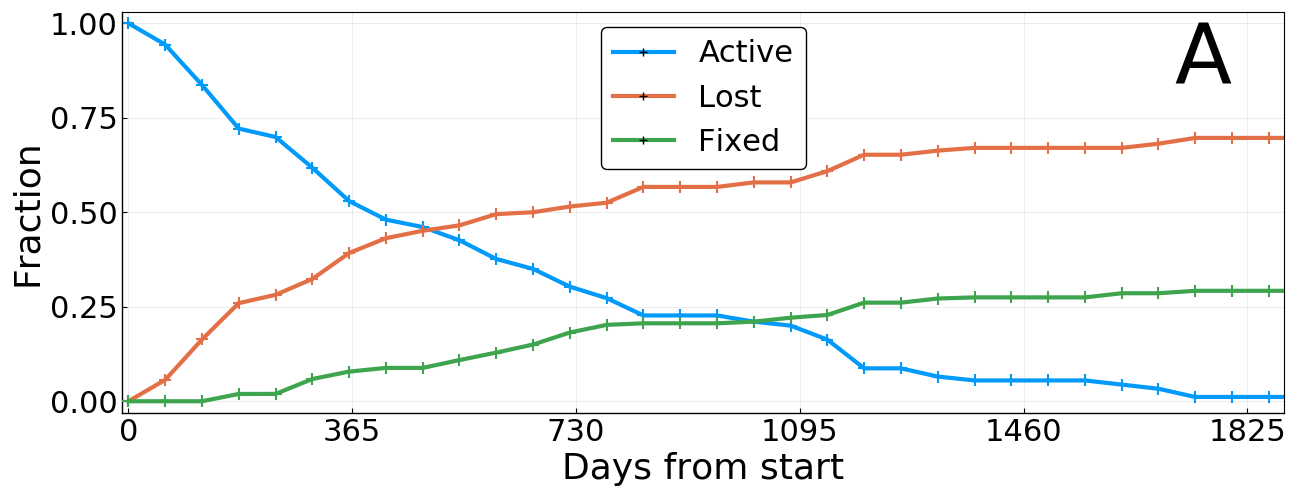

In [102]:
p = plot(times, active .+ 0.0001, label="Active", line = (3), marker=(:+, 8))
plot!(times, lost, label="Lost", line = (3), marker=(:+, 8))
plot!(times, fixed, label="Fixed", line = (3), marker=(:+, 8))
plot!(xlim = (-10,5*365 + 60))
plot!(xticks=[i*365 for i in 0:5])
plot!(p,size=(1280, 480),frame=:box, title="", xlabel="Days from start", ylabel="Fraction")
plot!(p, tickfontsize=tfs, legendfontsize=lfs, guidefontsize=alfs,titlefontsize=alfs)
annotate!(p, 4.8*365, 0.9, text("A", 60))
p3_sb1 = p
savefig("$(plotfolder_article)/Panel3_sb1.png")


## Pfix v freq

In [201]:
binwidth = Day(30);
binspacing = Day(30);
startdate = Date(2000)
Flu.bin_by_date!(fp, start=startdate, binwidth=binwidth, binspacing = binspacing);

In [202]:
ph_all = Flu.PosEvo(fp);

In [203]:
trajectories = Flu.all_trajectories(ph_all, keep_unfinished=false)
trajectories = Flu.previous_state_condition(trajectories, :lost)
# trajectories = Flu.population_size_condition(trajectories, 5, mode=:overall);
Flu.get_strains!(trajectories, fp)

In [204]:
alphabins_ = 0.1:0.1:0.9
alphabins = [(a, 0.05) for a in alphabins_];

In [205]:
traj_fb = trajectory_freqbin(trajectories, alphabins);
# Keeping only trajectories that have a frequency backed by 50 strains at the time where it is binned. 
for (k,v) in traj_fb
    traj_fb[k] = Flu.population_size_condition(v, 20, mode=:active)
end

In [206]:
xf, yf, errf = pfix_v_freq(ph_all, alphabins);

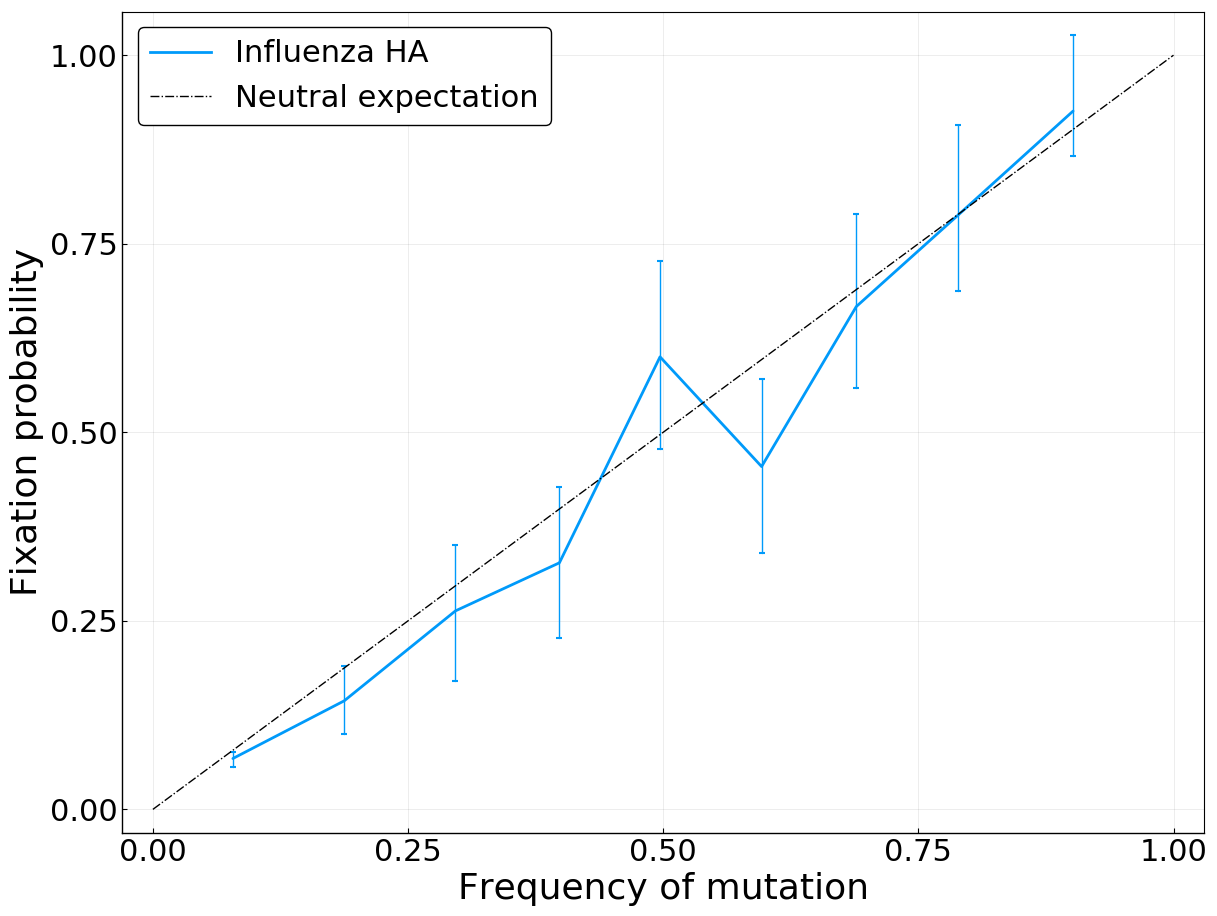

In [207]:
p = plot(size = (1200,900))
plot!(p, xf, yf, yerr=errf, label="Influenza HA", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("$(plotfolder)/Pfix_v_freq_HA.png")

In [208]:
# And adding NA
na_aln = "../../data/aligned_h3n2_na_aa.fasta"
fp_na = Flu.FluPop(na_aln, :aa, Flu.flu_usual_header_fields, flulineage="h3n2", segment="na");
Flu.bin_by_date!(fp_na, start=startdate, binwidth=binwidth, binspacing=binspacing);
ph_na = Flu.PosEvo(fp_na);

Reading ../../data/aligned_h3n2_na_aa.fasta...
Read 36300 strains out of 39312. Filtered 3012. Could not read 0


In [209]:
xna,yna,errna = pfix_v_freq(ph_na, alphabins);
xha, yha, errha = pfix_v_freq(ph_all, alphabins);

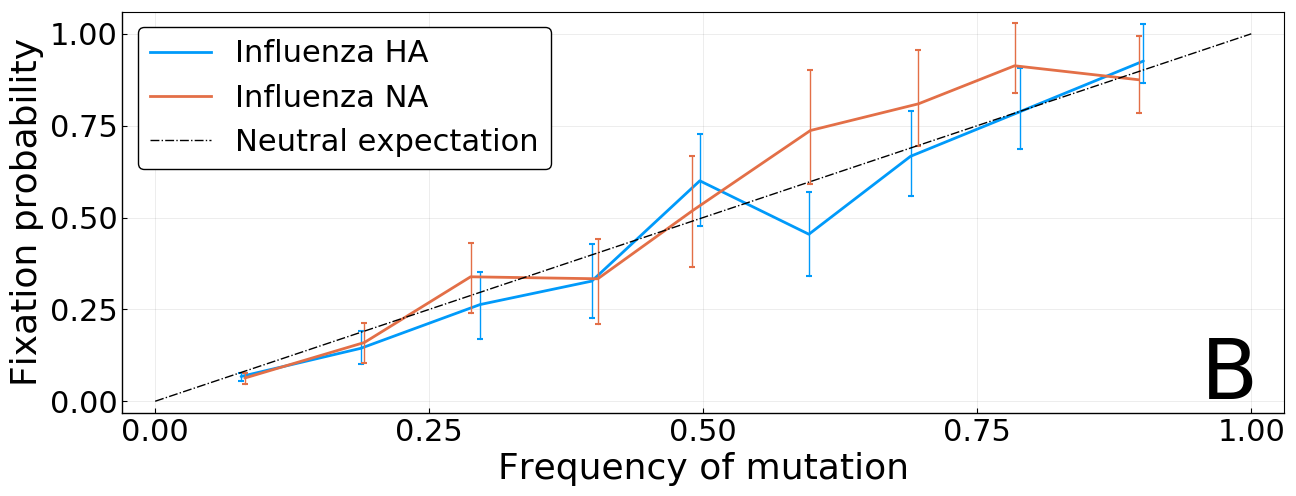

In [210]:
p = plot(size = (1200,900))
plot!(p, xha, yha, yerr=errha, label="Influenza HA", line=(2))
plot!(p, xna, yna, yerr=errna, label="Influenza NA", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("$(plotfolder)/Pfix_v_freq_HANA.png")

p3_sb2 = plot(p, size=(1280,480))
annotate!(p3_sb2, 0.98, 0.07, text("B", 60))
savefig("$(plotfolder)/Panel3_sb2.png")

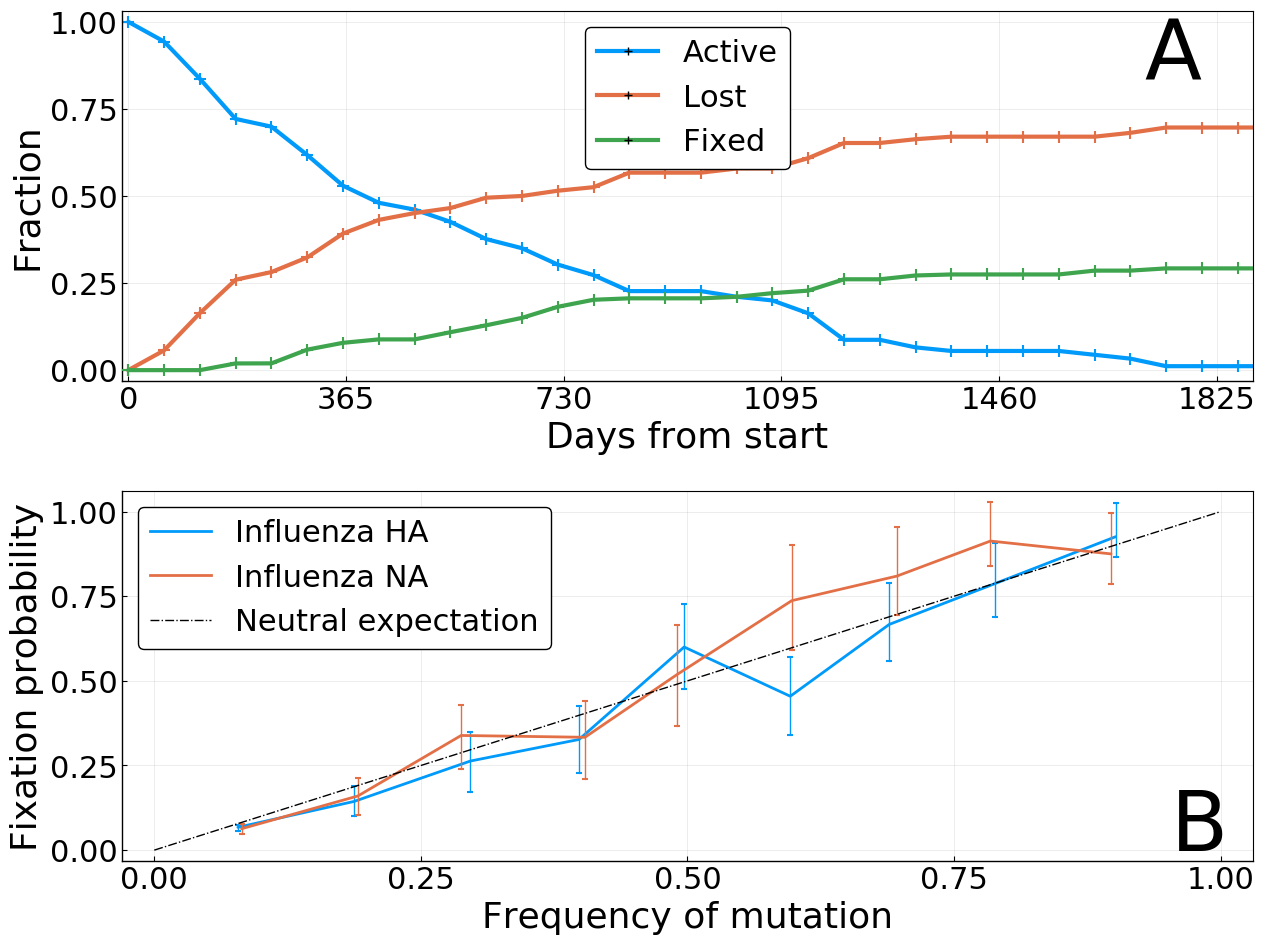

In [211]:
p3 = plot(p3_sb1, p3_sb2, layout=grid(2,1), size=(1280, 960), margin=5mm)
savefig("$(plotfolder_article)/Panel3.png")

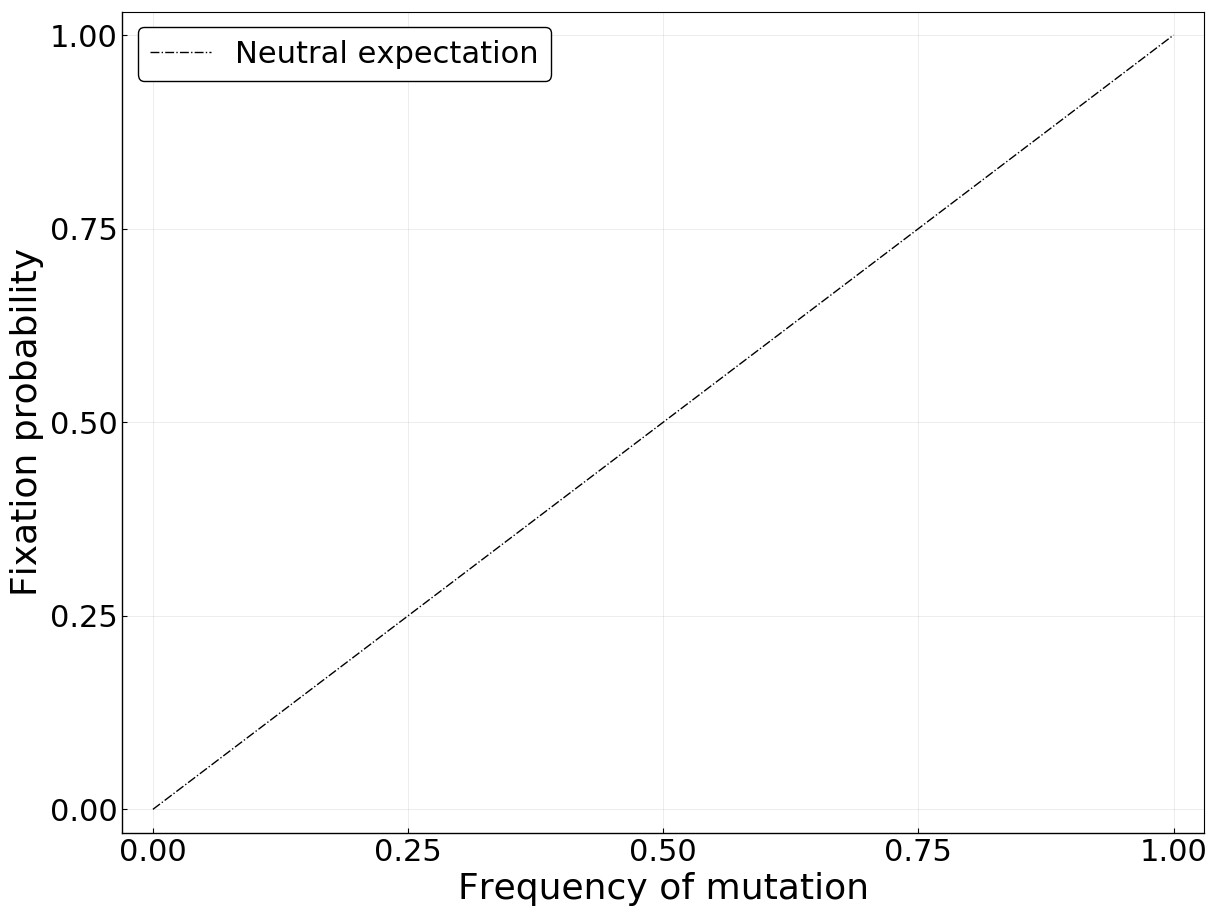

In [212]:
p = plot(size = (1200,900))
# plot!(p, dat[:,1], dat[:,2], yerr=err, label="Influenza HA", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("$(plotfolder)/Pfix_v_freq_neutral.png");

## Positive derivative

In [213]:
xha, yha, errha = pfix_v_freq_positivederivative(ph_all, alphabins);
xna, yna, errna = pfix_v_freq_positivederivative(ph_na, alphabins);

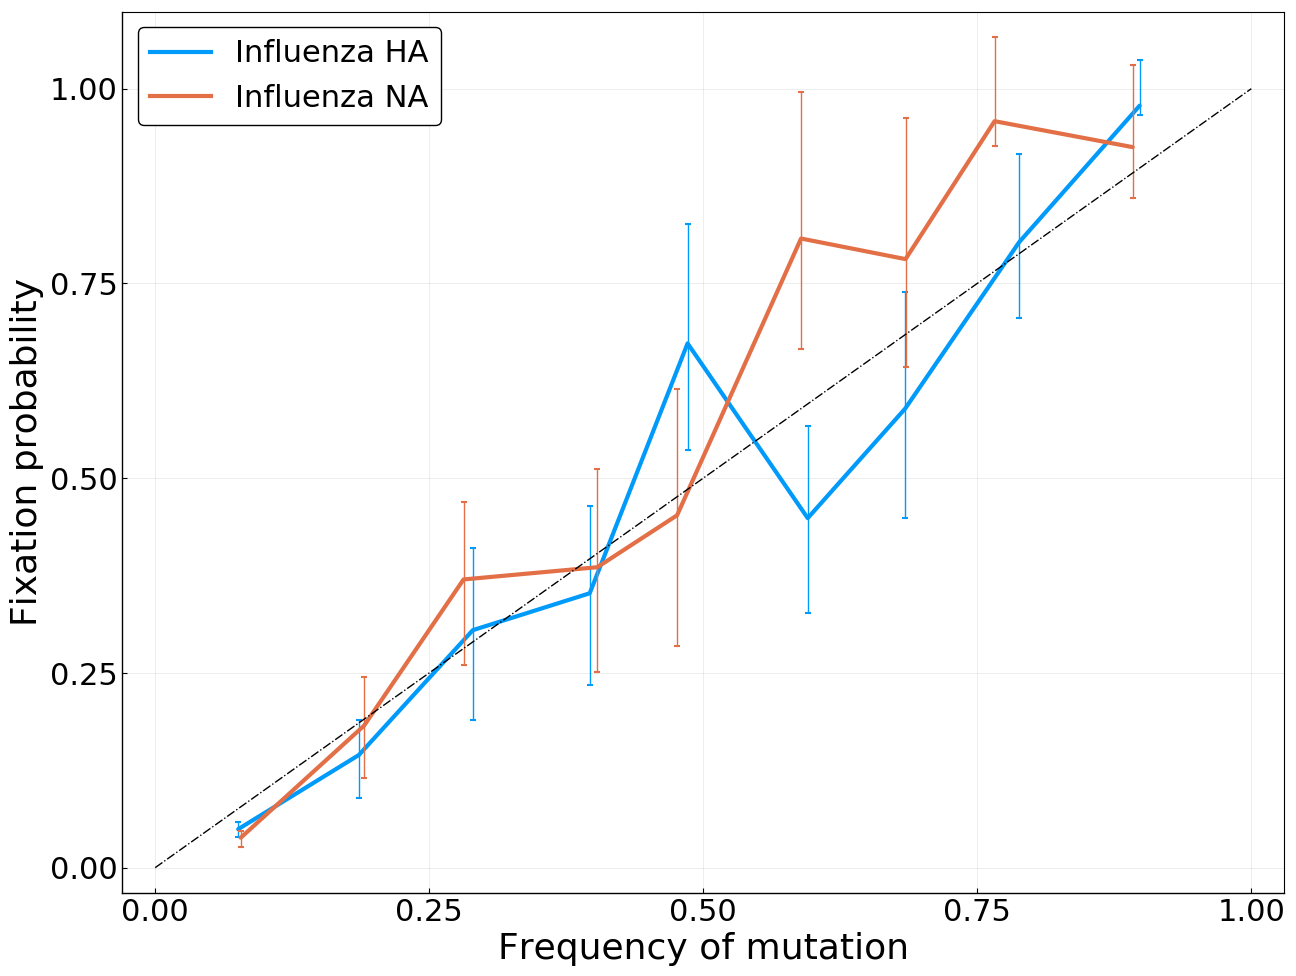

In [310]:
p = plot(size = (1280,960))
plot!(p, xha, yha, yerr=errha, label="Influenza HA", line=(3))
plot!(p, xna, yna, yerr=errna, label="Influenza NA", line=(3))
# plot!(p, xf, yf, yerr=errf, label="Influenza HA", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("$(plotfolder)/Pfix_v_freq_posdev.png");
p_sm1_sb3 = p;

# Treespread

In [215]:
function fitness_plot(trajectories, field; verbose=false)
    traj_fb = trajectory_freqbin(trajectories, alphabins);
    # Keeping only trajectories that have a frequency backed by 50 strains at the time where it is binned. 
    for (k,v) in traj_fb
        traj_fb[k] = Flu.population_size_condition(v, 20, mode=:active)
    end   
    # High and low fitnesses
    high_fit = Dict()
    low_fit = Dict()
    for (k,v) in traj_fb
        fvalues = [x.data[field][x.index[:active]] for x in v]
        medfit = median(fvalues)
        verbose && println("Frequency $k -- median fitness $(medfit)")
        high_fit[k] = v[findall(x->x.data[field][x.index[:active]] > medfit, v)]
        low_fit[k] = v[findall(x->x.data[field][x.index[:active]] <= medfit, v)]
    end
    # Arrays
    dat = vcat([[meanfreq(traj_fb[x]) pfix(traj_fb[x])] for x in alphabins_]...)
    dat_low = vcat([[meanfreq(traj_fb[x]) pfix(low_fit[x])] for x in alphabins_]...)
    dat_high = vcat([[meanfreq(traj_fb[x]) pfix(high_fit[x])] for x in alphabins_]...)
    return dat, dat_low, dat_high
end

fitness_plot (generic function with 1 method)

In [216]:
t = read_tree("../../data/trees/tree_building_ha_100permonth/tree_refined.nwk");
mutfile = "../../data/trees/tree_building_ha_100permonth/aa_muts.json"
Flu.read_mutations!(t, mutfile);

  2.812947 seconds (4.39 M allocations: 678.706 MiB, 59.16% gc time)
NODE_0017638
NODE_0017638
NODE_0017638


In [217]:
for traj in trajectories
    Flu.compute_tree_spread!(traj, t, fp)
end
Flu.compute_fitness!(trajectories, fp, :treespread,)
dat, dat_low, dat_high = fitness_plot(trajectories, :treespread_fitness);

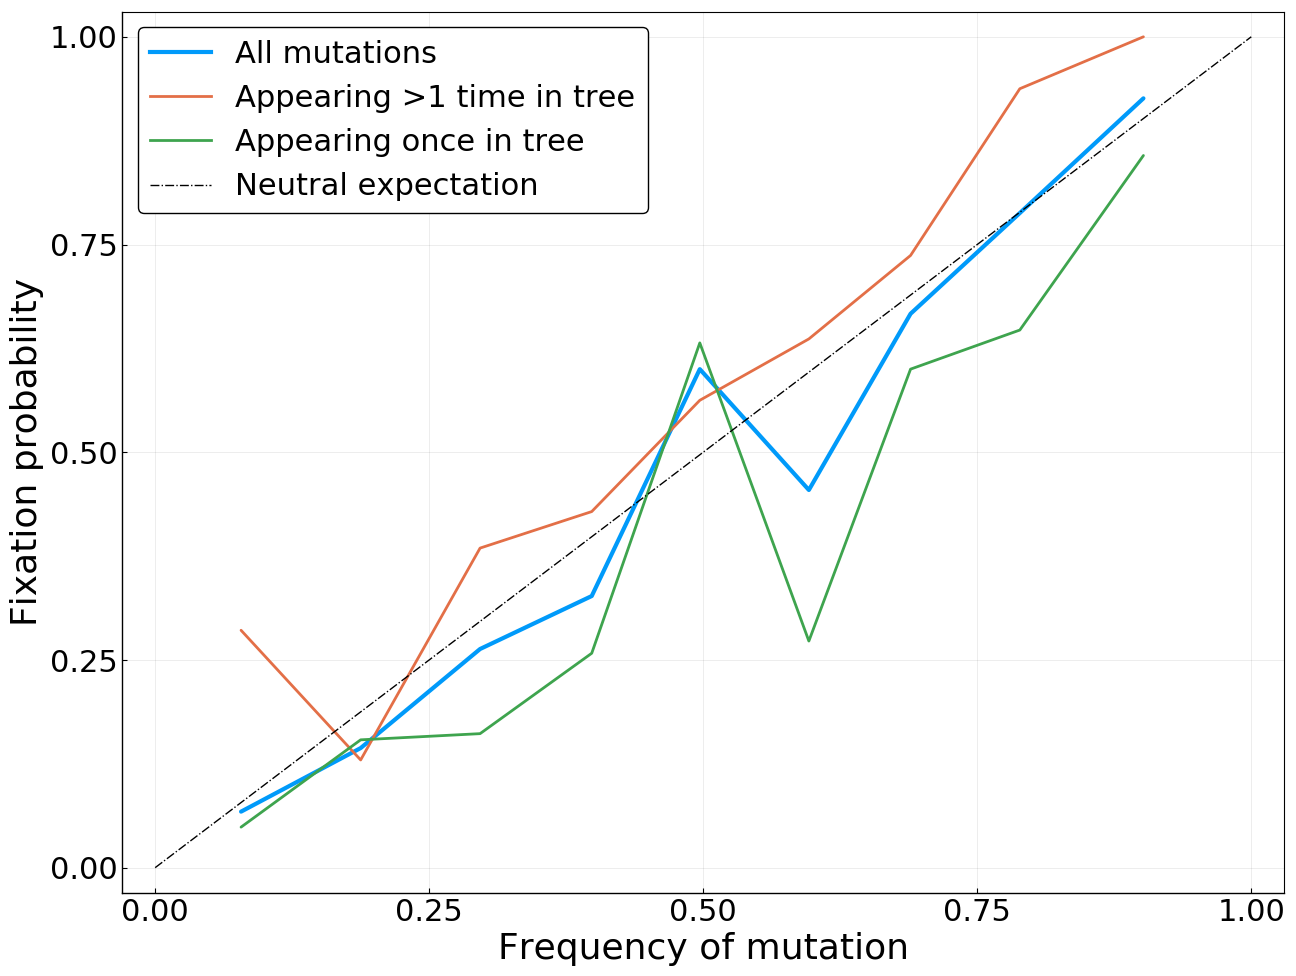

In [311]:
p = plot(size = (1280,960))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat[:,1], dat_high[:,2], label="Appearing >1 time in tree", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Appearing once in tree", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("$(plotfolder)/Pfix_v_freq_treespread.png")
p_sm1_sb1 = p;

# LBI

In [220]:
t = read_tree("../../data/trees/tree_building_ha_100permonth/tree_refined.nwk", NodeDataType=LBIData);

  3.270736 seconds (4.32 M allocations: 673.715 MiB, 55.20% gc time)


In [221]:
Flu.get_lbi!(fp, t, verbose=false)

┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

In [222]:
Flu.compute_fitness!(trajectories, fp, :strains, strainfield=:lbi);

In [223]:
trajectories[1].data

Dict{Any,Any} with 3 entries:
  :treespread_fitness => [0.0, 0.0, 0.0, 0.0, 0.833333, 0.0, 0.763889, 0.88, 0.…
  :treespread         => Array{Int64,1}[[], [1], [2], [], [1, 1, 1, 1, 1, 1], […
  :lbi_fitness        => [0.0, -0.000471809, 0.00559491, 0.0, -0.00397009, -0.0…

In [224]:
dat, dat_low, dat_high = fitness_plot(trajectories, :lbi_fitness);

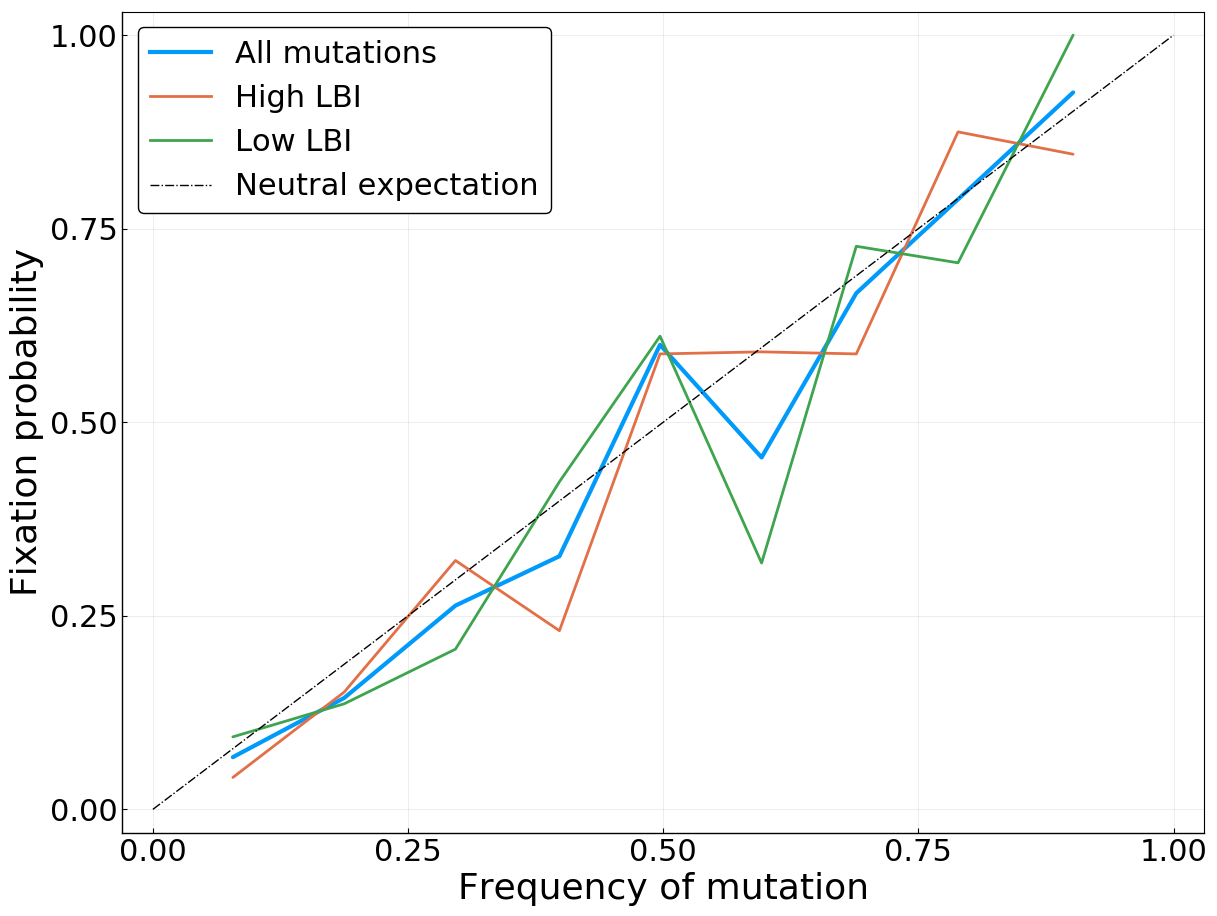

In [225]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat[:,1], dat_high[:,2], label="High LBI", line=(2), color=2)
plot!(p, dat[:,1], dat_low[:,2], label="Low LBI", line=(2), color=3)
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("$(plotfolder)/Pfix_v_freq_LBI.png")

# Date and region

## Date

In [226]:
Flu.compute_fitness!(trajectories, fp, :date)
dat, dat_low, dat_high = fitness_plot(trajectories, :date_fitness);

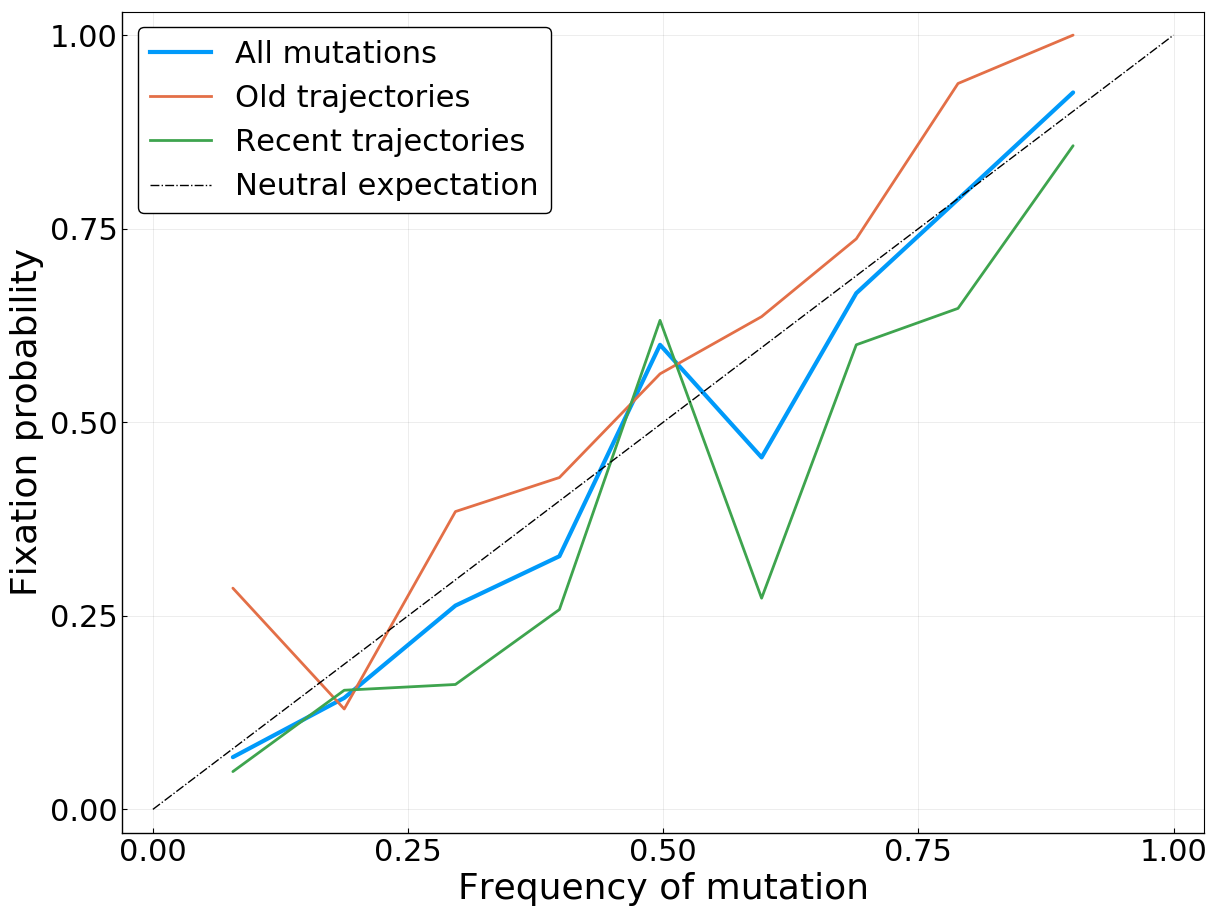

In [227]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat[:,1], dat_high[:,2], label="Old trajectories", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Recent trajectories", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("$(plotfolder)/Pfix_v_freq_date.png")

## Region

In [228]:
Flu.get_regions!(trajectories, fp)

In [229]:
Flu.compute_fitness!(trajectories, fp, :region);
# dat, dat_low, dat_high = fitness_plot(trajectories, :region_fitness);

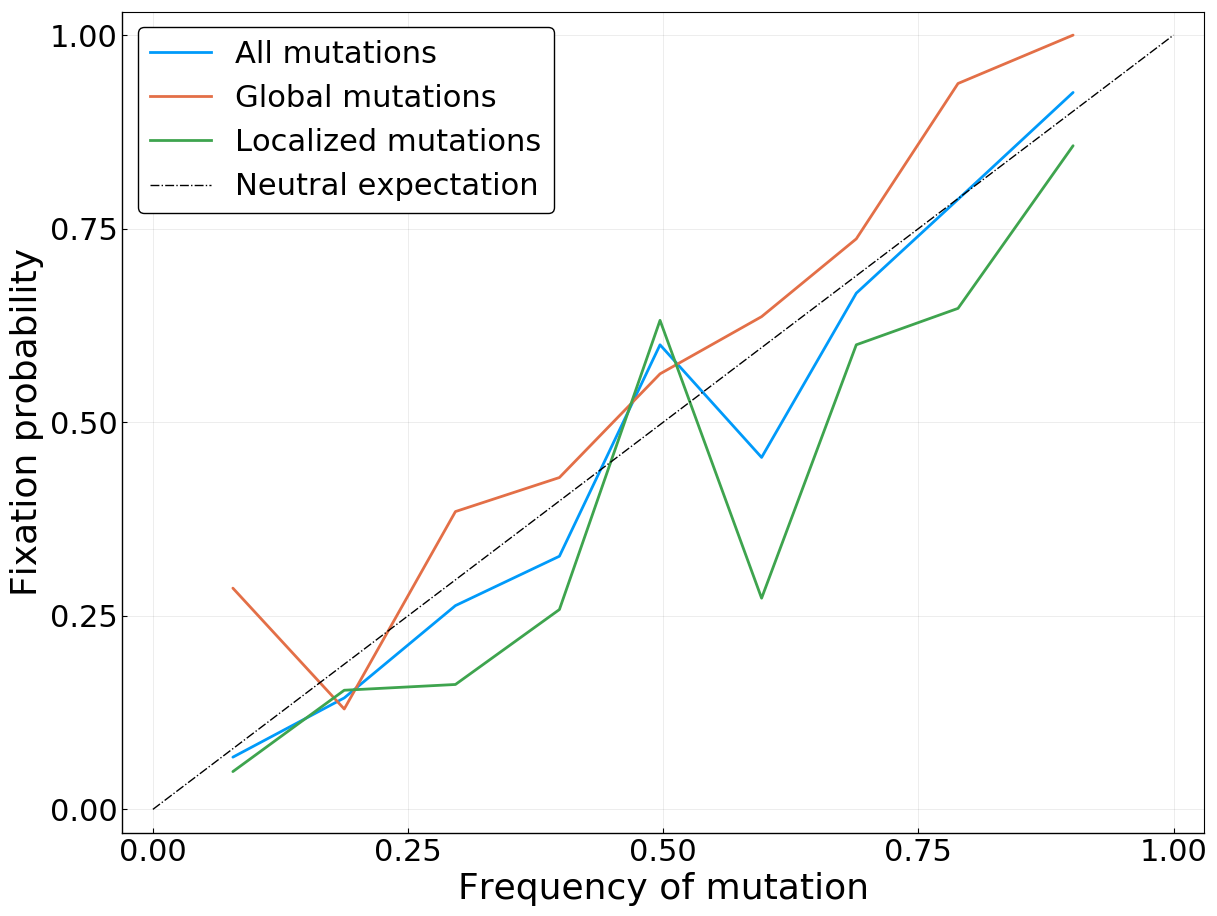

In [230]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(2))
plot!(p, dat[:,1], dat_high[:,2], label="Global mutations", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Localized mutations", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("LongTerm/Pfix_v_freq_region.png")

In [231]:
trajectories[1].data[:region_fitness]

10-element Array{Float64,1}:
  0.0               
 -0.0               
 -0.0               
  0.0               
  0.8675632284814612
 -0.0               
  0.9586918593253719
  0.8101502323878818
 -0.0               
  0.0               

### Correlation between geography and duration? 

In [233]:
r = Dict()
for x in trajectories
    for i in 1:length(x)
        r[x.data[:date_fitness][i]] = push!(get(r, x.data[:date_fitness][i], []), x.data[:region_fitness][i])
#         push!(t, x.data[:date_fitness][i])
#         push!(r, x.data[:region_fitness][i])
    end
end
r_v_t = sort(Dict(t=>mean(v) for (t,v) in r))
for k in keys(r_v_t)
    if k > 1000
        delete!(r_v_t, k)
    end
end

In [313]:
x = vcat([collect(values(t.data[:date_fitness])) for t in trajectories]... )
y = vcat([collect(values(t.data[:region_fitness])) for t in trajectories]... );

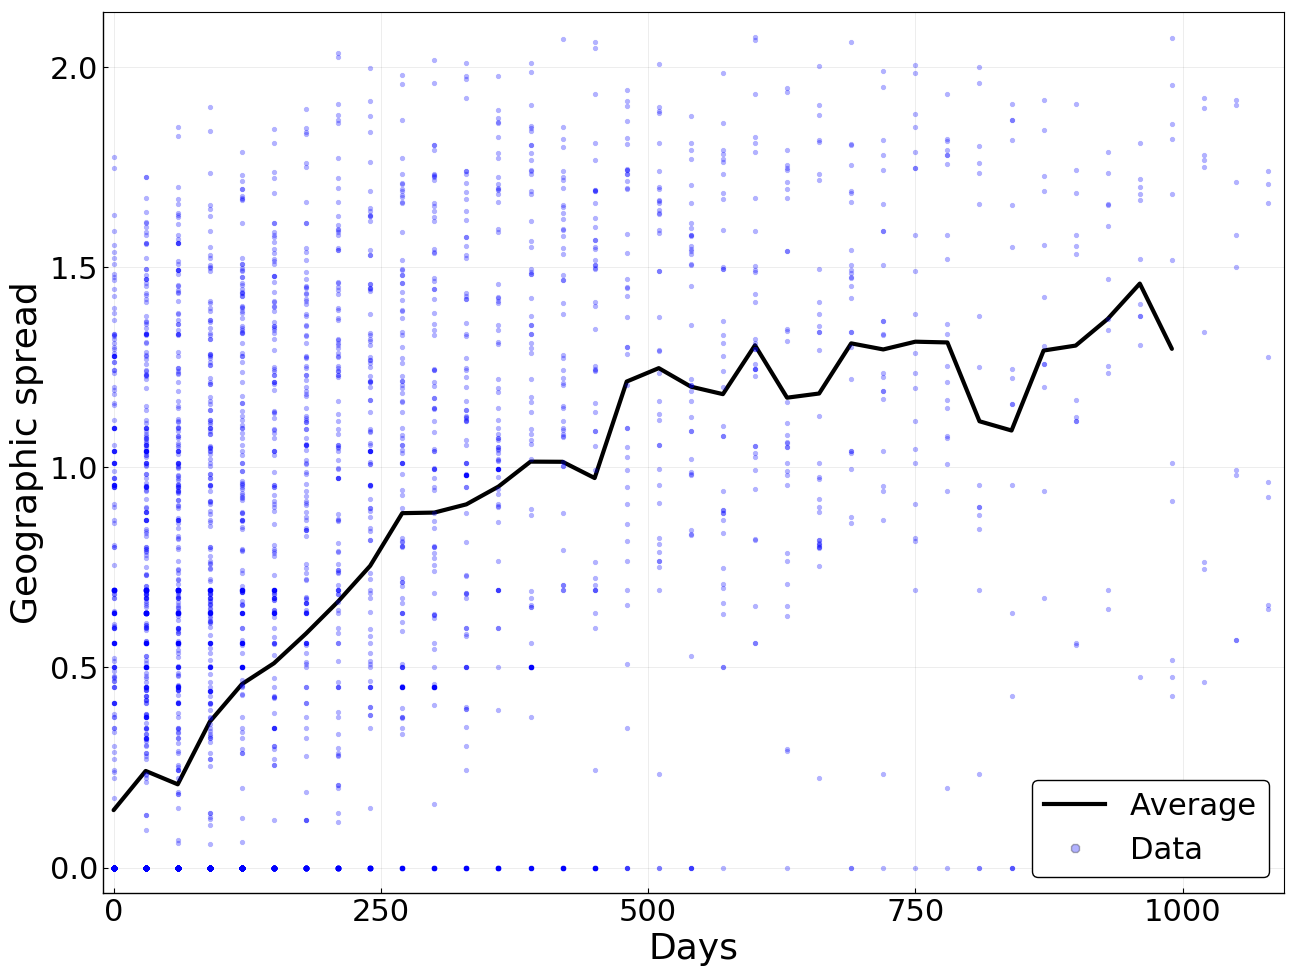

In [314]:
p = plot([x[1] for x in r_v_t], [x[2] for x in r_v_t], label="Average", line=(:black,3))
scatter!(x,y,marker=(:blue, 4,:o,0.3), markerstrokewidth=0, label="Data")
plot!(p, xlabel="Days", ylabel="Geographic spread", size=(1280,960))
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
plot!(xlim=(-10,3*365))
savefig(p, "$(plotfolder)/geospread_vs_time.png")
savefig(p, "$(plotfolder_SM)/GeoSpread_v_time_ha.png")

## Epitope positions

In [235]:
# function Pfix_v_freq(ph, alphabins)
#     trajectories = Flu.all_trajectories(ph, keep_unfinished=false)
#     trajectories = Flu.previous_state_condition(trajectories, :lost)
#     traj_fb = sort(trajectory_freqbin(trajectories, alphabins));
#     # Keeping only trajectories that have a frequency backed by 50 strains at the time where it is binned. 
#     for (k,v) in traj_fb
#         traj_fb[k] = Flu.population_size_condition(v, 20, mode=:active)
#     end
#     n = [length(traj_fb[x]) for x in keys(traj_fb)]
#     x = [count(t->t.fixation==:fixed, traj_fb[x]) for x in keys(traj_fb)]
#     out = bernoulli_estimator.(x,n)
#     # 
#     xf = [meanfreq(traj_fb[x]) for x in keys(traj_fb)]
# #     yf = [x[1] for x in out]; 
#     yf = [count(t->t.fixation==:fixed, traj_fb[x])/length(traj_fb[x])
#         for x in keys(traj_fb)]
    
#     return xf, yf
# end

In [236]:
authors = ("Koel", "Luksza", "Shih", "Wolf")
path = "../../data/epitopes/ha";


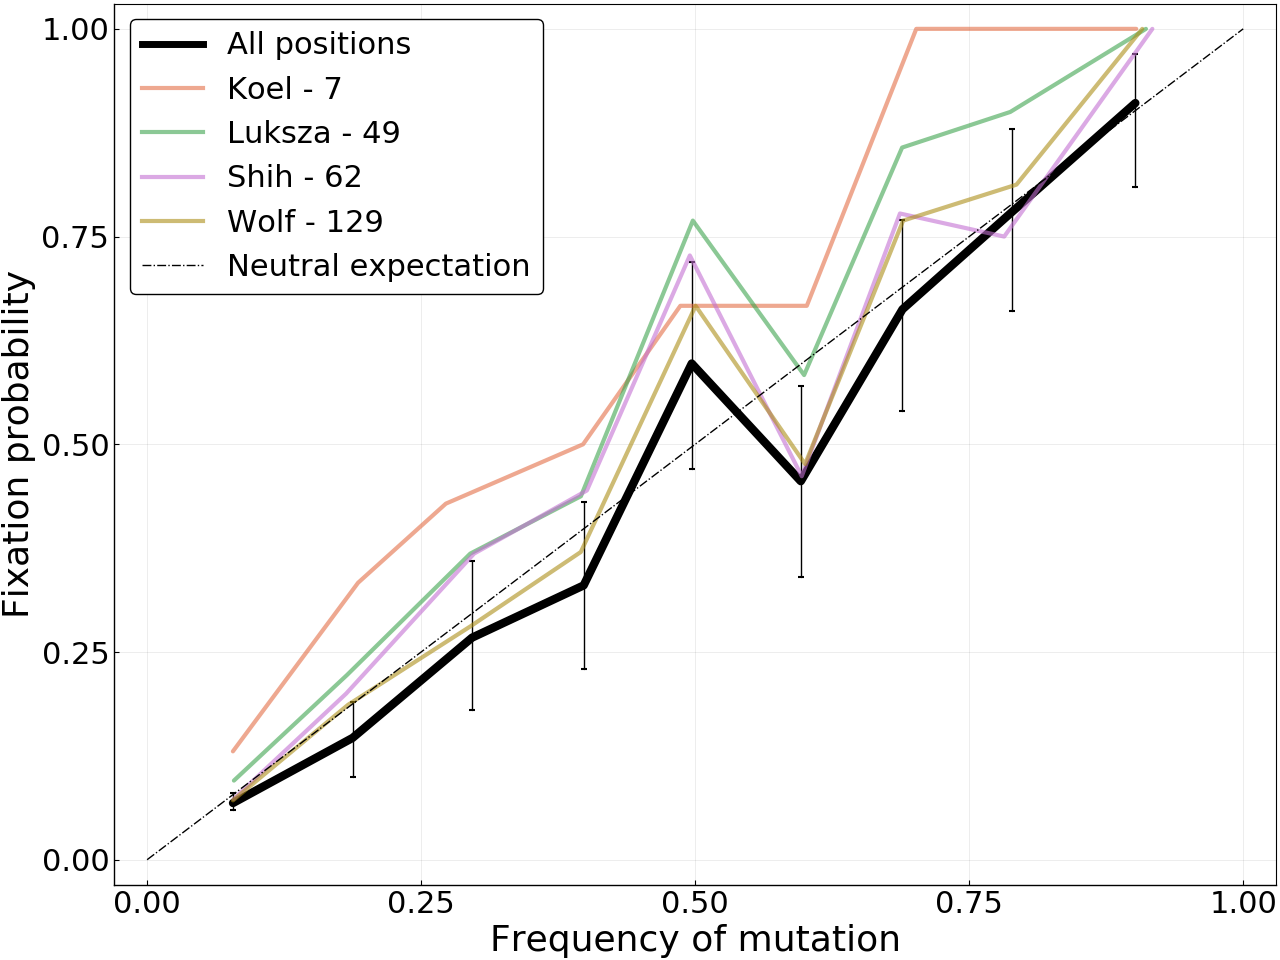

In [315]:
n = [length(traj_fb[x]) for x in alphabins_]
x = [count(t->t.fixation==:fixed, traj_fb[x]) for x in alphabins_]
out = bernoulli_estimator.(x,n)
# 
xf = [meanfreq(traj_fb[x]) for x in alphabins_]
yf = [x[1] for x in out]; 
errup = [x[3] for x in out]; errdown = [x[2] for x in out]
# 
p = plot(size = (1280,960))
plot!(p, xf, yf, err=(errdown, errup), line=(:black, 6), 
    markercolor=:black, markerstrokecolor=:black, label="All positions")
# Epitopes
for a in authors[1:end]
    pos = vec(readdlm("$(path)/epitope_positions_$(lowercase(a)).txt", Int64))
    x,y = pfix_v_freq(ph_all[pos], alphabins)
    plot!(p, x, y, line=(3), alpha=0.6, label="$a - $(length(pos))")
end
#
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(p, xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
# savefig("$(plotfolder)/Pfix_v_freq_epitope.png")

# Panel 4

## LBI

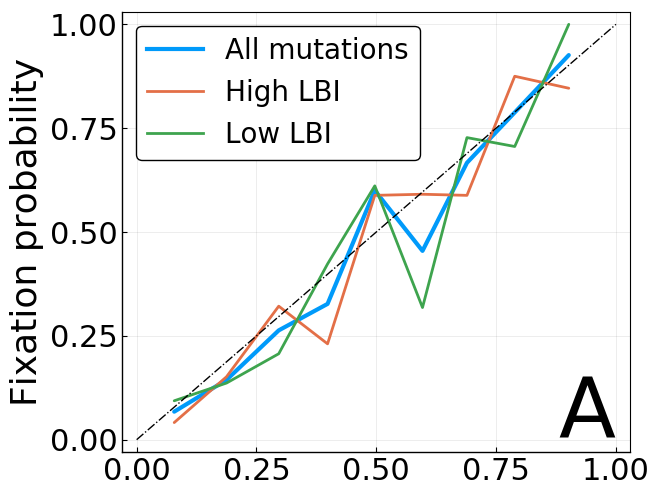

In [278]:
dat, dat_low, dat_high = fitness_plot(trajectories, :lbi_fitness);
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat[:,1], dat_high[:,2], label="High LBI", line=(2), color=2)
plot!(p, dat[:,1], dat_low[:,2], label="Low LBI", line=(2), color=3)
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs-2, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p4_sb1 = plot(p, size=(640,480))
annotate!(0.94, 0.06, text("A",60))
savefig("$(plotfolder_article)/Panel4_sb1.png")

## Epitopes

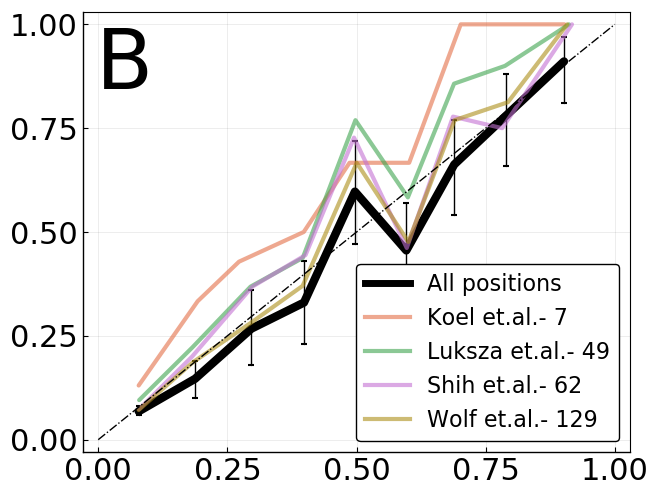

In [279]:
authors = ("Koel", "Luksza", "Shih", "Wolf")
path = "../../data/epitopes/ha";
n = [length(traj_fb[x]) for x in alphabins_]
x = [count(t->t.fixation==:fixed, traj_fb[x]) for x in alphabins_]
out = bernoulli_estimator.(x,n)
# 
xf = [meanfreq(traj_fb[x]) for x in alphabins_]
yf = [x[1] for x in out]; 
errup = [x[3] for x in out]; errdown = [x[2] for x in out]
# 
p = plot(size = (1200,900))
plot!(p, xf, yf, err=(errdown, errup), line=(:black, 6), 
    markercolor=:black, markerstrokecolor=:black, label="All positions")
# Epitopes
for a in authors[1:end]
    pos = vec(readdlm("$(path)/epitope_positions_$(lowercase(a)).txt", Int64))
    x,y = pfix_v_freq(ph_all[pos], alphabins)
    plot!(p, x, y, line=(3), alpha=0.6, label="$a et.al.- $(length(pos))")
end
#
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(p, xlabel="", ylabel="")
plot!(p, legendfontsize=lfs-6, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p4_sb2 = plot(p, size=(640,480))
annotate!(0.05, 0.9, text("B",60))
savefig("$(plotfolder_article)/Panel4_sb2.png")

## Geography

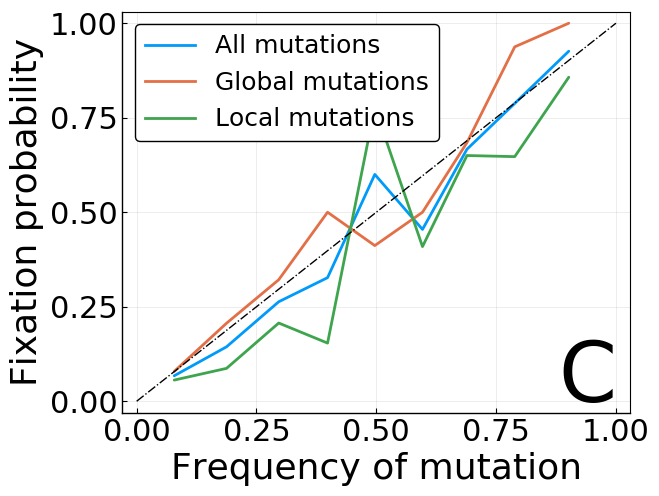

In [280]:
dat, dat_low, dat_high = fitness_plot(trajectories, :region_fitness);
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(2))
plot!(p, dat[:,1], dat_high[:,2], label="Global mutations", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Local mutations", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs-4, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p4_sb3 = plot(p, size=(640,480))
annotate!(0.94, 0.06, text("C",60))
savefig("$(plotfolder_article)/Panel4_sb3.png")

## Date

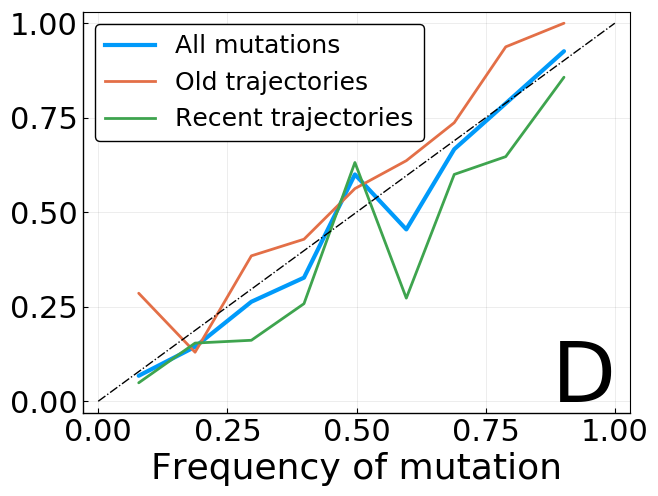

In [281]:
dat, dat_low, dat_high = fitness_plot(trajectories, :date_fitness);
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat[:,1], dat_high[:,2], label="Old trajectories", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Recent trajectories", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="")
plot!(p, legendfontsize=lfs-4, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p4_sb4 = plot(p, size=(640, 480))
annotate!(0.94, 0.06, text("D",60))
savefig("$(plotfolder_article)/Panel4_sb4.png")

## Panel

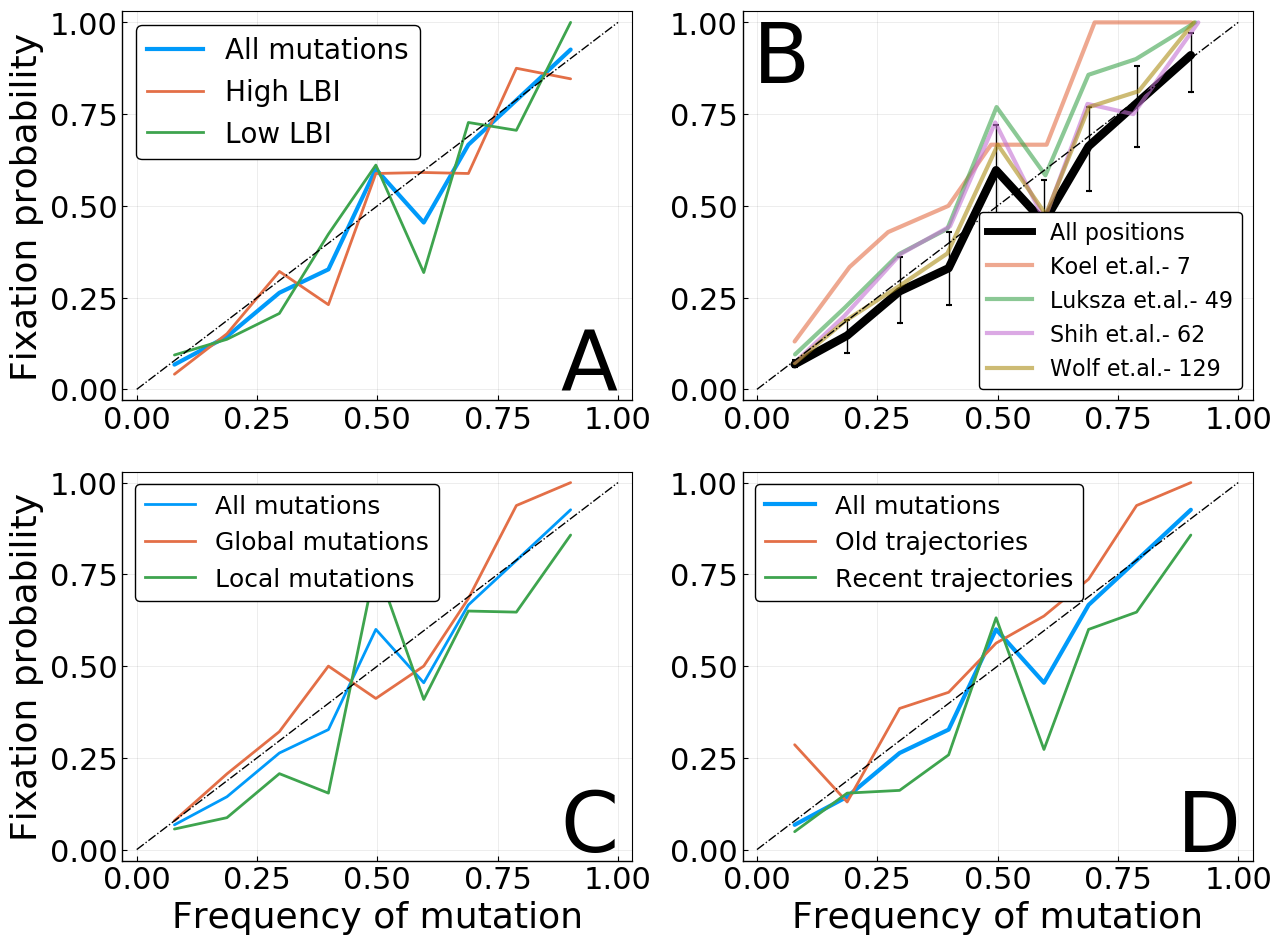

In [282]:
plot(p4_sb1, p4_sb2, p4_sb3, p4_sb4, layout = grid(2,2), size=(1280,960), margin= 5mm)
savefig("$(plotfolder_article)/Panel4.png")

## RBS

In [143]:
# All positions
trajectories = Flu.all_trajectories(ph_all, keep_unfinished=false)
trajectories = Flu.previous_state_condition(trajectories, :lost)
traj_fb = trajectory_freqbin(trajectories, alphabins);
# Keeping only trajectories that have a frequency backed by 50 strains at the time where it is binned. 
for (k,v) in traj_fb
    traj_fb[k] = Flu.population_size_condition(v, 20, mode=:active)
end

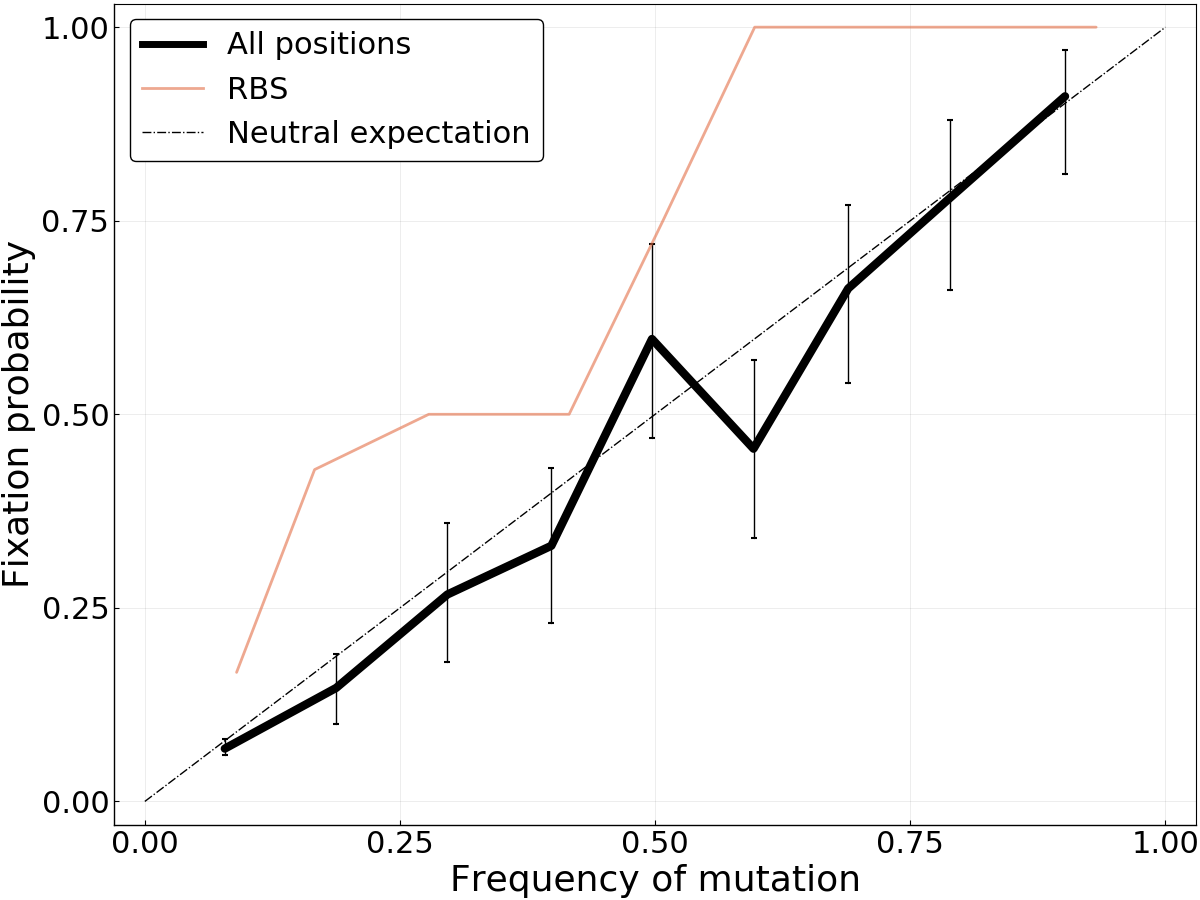

In [144]:
n = [length(traj_fb[x]) for x in alphabins_]
x = [count(t->t.fixation==:fixed, traj_fb[x]) for x in alphabins_]
out = bernoulli_estimator.(x,n)
# 
xf = [meanfreq(traj_fb[x]) for x in alphabins_]
yf = [x[1] for x in out]; 
errup = [x[3] for x in out]; errdown = [x[2] for x in out]
# 
p = plot(size = (1200,900))
plot!(p, xf, yf, err=(errdown, errup), line=(:black, 6), 
    markercolor=:black, markerstrokecolor=:black, label="All positions")
# Epitopes
pos = vec(readdlm("../../data/rbs_ha.txt", Int64))
x,y = pfix_v_freq(ph_all[pos], alphabins)
plot!(p, x, y, line=(2), alpha=0.6, label="RBS")

#
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(p, xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
# savefig("$(plotfolder)/Pfix_v_freq_epitope.png")

## Binary positions
Positions for which only 2 amino acids are seen at any given time

In [145]:
binpos = vec(readdlm("../../data/binary_positions_ha.txt", Int64));

In [146]:
# All positions
trajectories = Flu.all_trajectories(ph_all[binpos], keep_unfinished=false)
trajectories = Flu.previous_state_condition(trajectories, :lost)
traj_fb = trajectory_freqbin(trajectories, alphabins);
# Keeping only trajectories that have a frequency backed by 50 strains at the time where it is binned. 
for (k,v) in traj_fb
    traj_fb[k] = Flu.population_size_condition(v, 20, mode=:active)
end

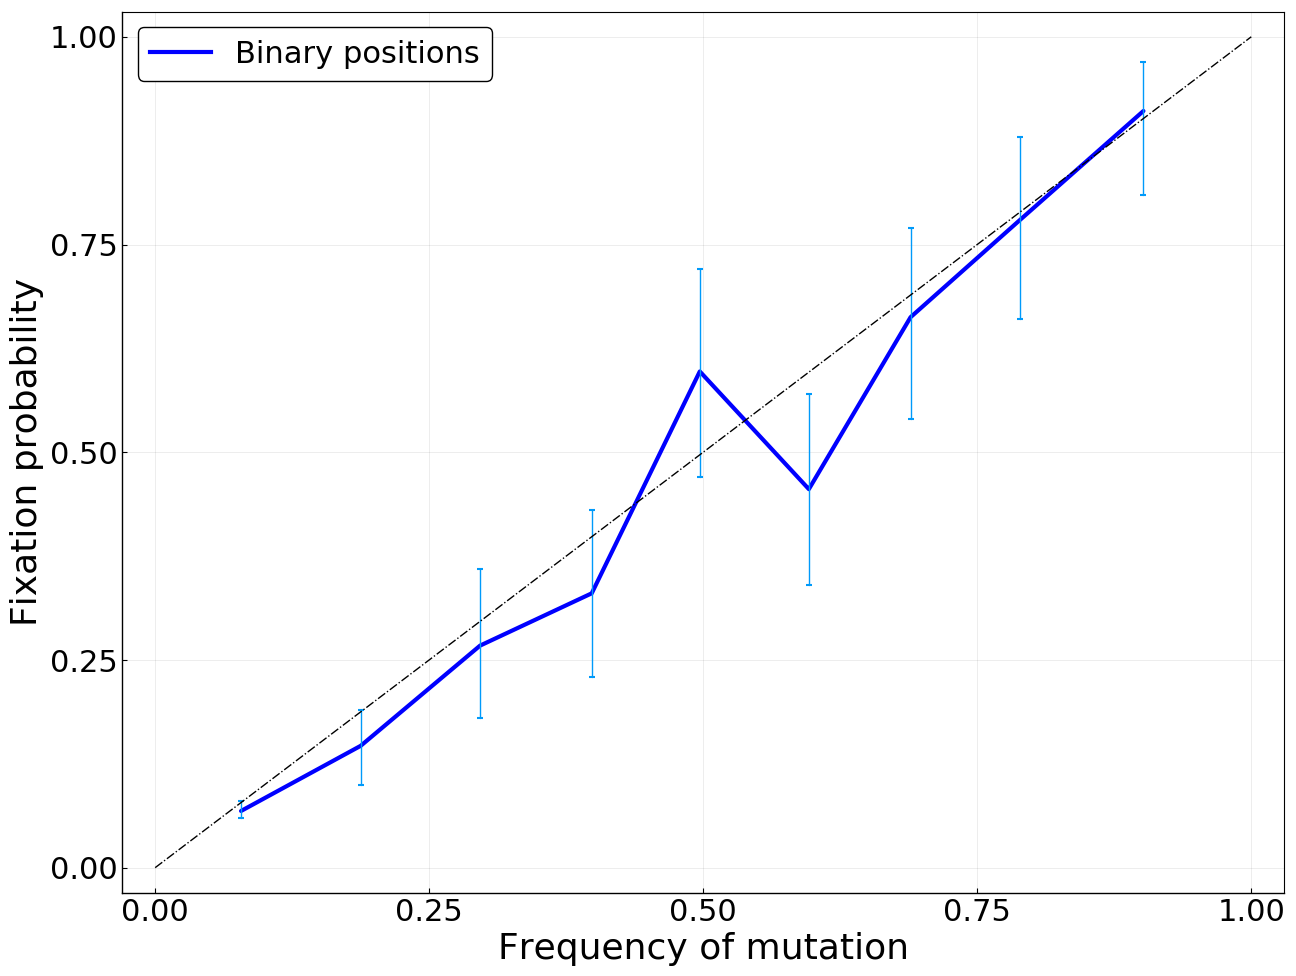

In [316]:
n = [length(traj_fb[x]) for x in alphabins_]
x = [count(t->t.fixation==:fixed, traj_fb[x]) for x in alphabins_]
out = bernoulli_estimator.(x,n)
# 
xf = [meanfreq(traj_fb[x]) for x in alphabins_]
yf = [x[1] for x in out]; 
errup = [x[3] for x in out]; errdown = [x[2] for x in out]
# 
p = plot(size = (1280,960))
plot!(p, xf, yf, err=(errdown, errup), line=(:blue, 3), label="Binary positions")

plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(p, xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig(p, "$(plotfolder)/Pfix_v_freq_binarypos.png")
p_sm1_sb2 = p;

# SM Panel

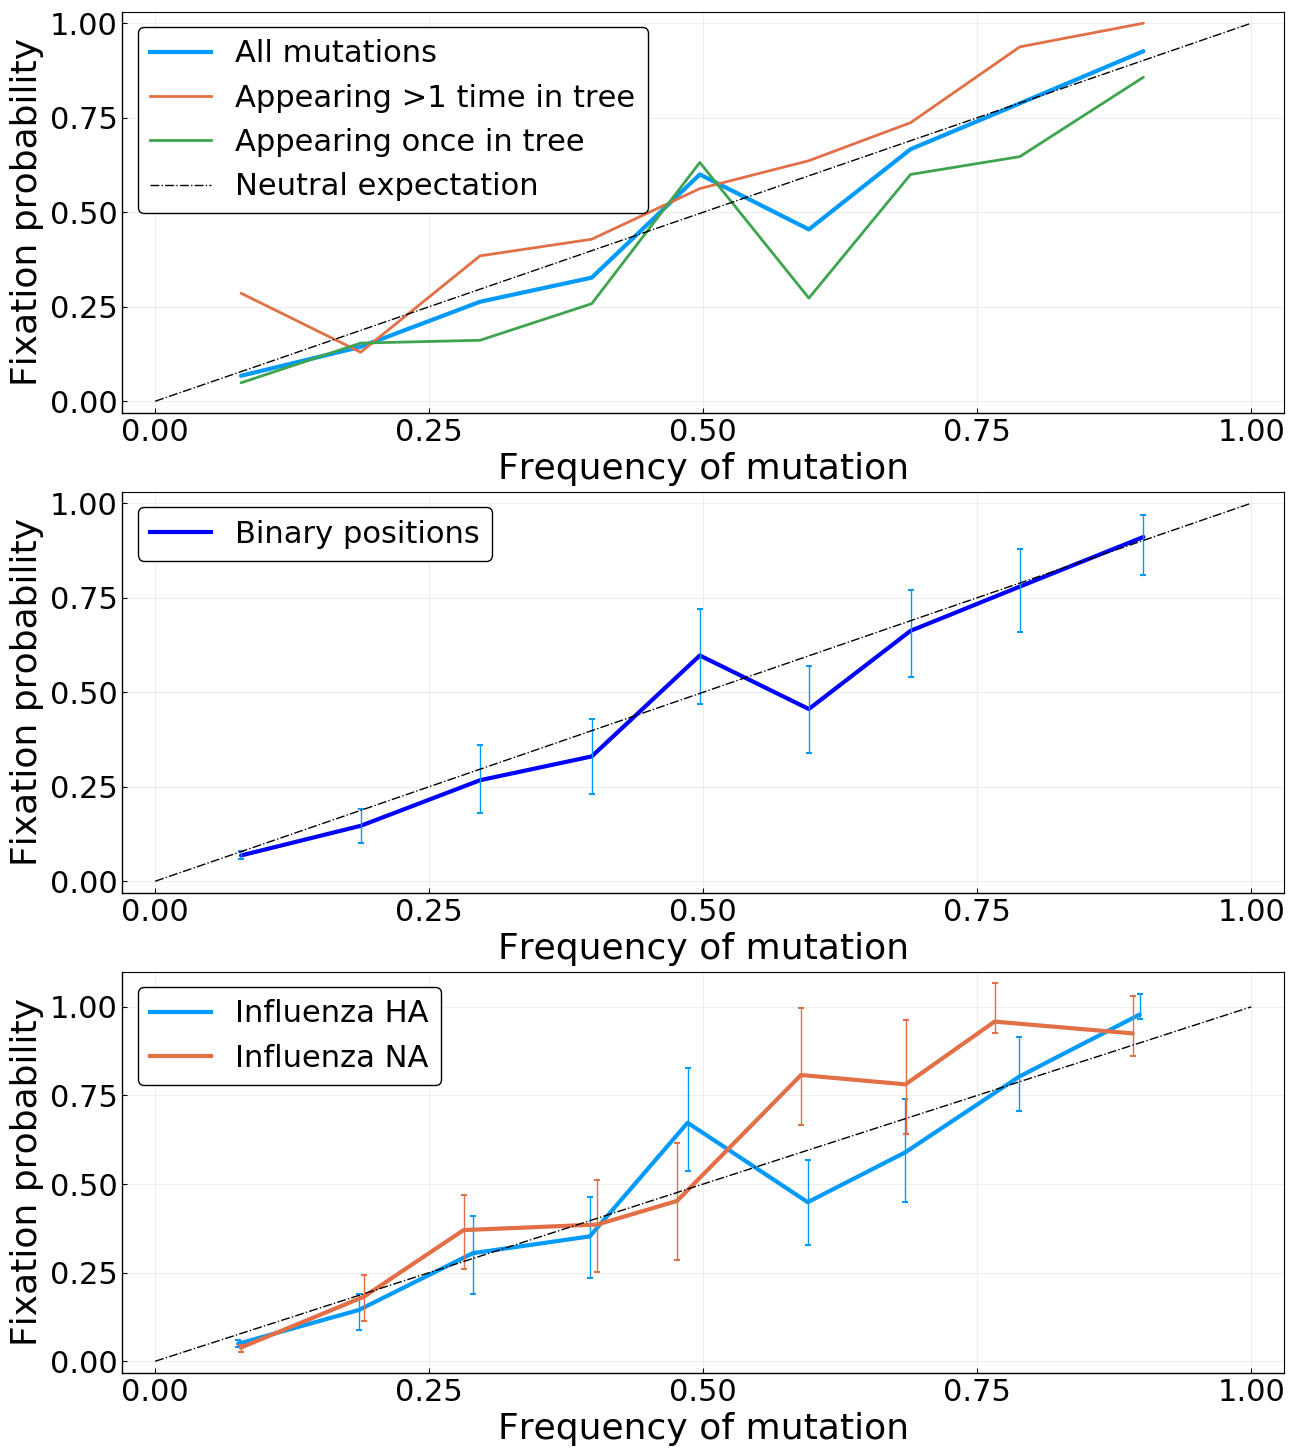

In [319]:
psm = plot(p_sm1_sb1, p_sm1_sb2, p_sm1_sb3, layout=grid(3,1), size=(1280,3*480))
savefig("$(plotfolder_SM)/Pfix_v_freq_misc.png")

# Large timebins

In [60]:
binwidth = Day(180);
binspacing = Day(180);
startdate = Date(2000)
Flu.bin_by_date!(fp, start=startdate, binwidth=binwidth, binspacing = binspacing);

In [61]:
ph_all = Flu.PosEvo(fp);

In [62]:
trajectories = Flu.all_trajectories(ph_all, keep_unfinished=false)
trajectories = Flu.previous_state_condition(trajectories, :lost)
# trajectories = Flu.population_size_condition(trajectories, 5, mode=:overall);
Flu.get_strains!(trajectories, fp)

In [63]:
alphabins_ = 0.1:0.1:0.9
alphabins = [(a, 0.05) for a in alphabins_];

In [64]:
traj_fb = trajectory_freqbin(trajectories, alphabins);
# Keeping only trajectories that have a frequency backed by 50 strains at the time where it is binned. 
for (k,v) in traj_fb
    traj_fb[k] = Flu.population_size_condition(v, 20, mode=:active)
end

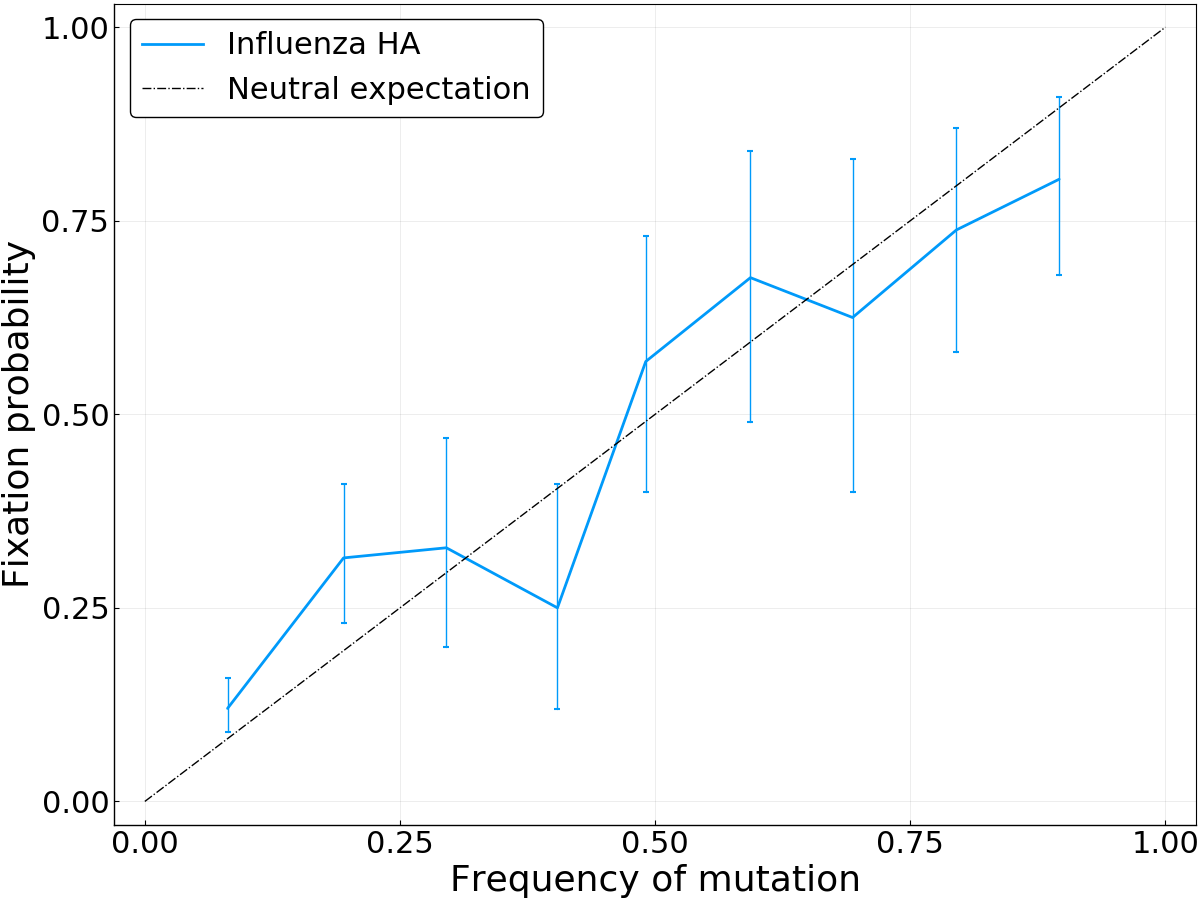

In [65]:
n = [length(traj_fb[x]) for x in alphabins_]
x = [count(t->t.fixation==:fixed, traj_fb[x]) for x in alphabins_]
out = bernoulli_estimator.(x,n)
# 
xf = [meanfreq(traj_fb[x]) for x in alphabins_]
yf = [x[1] for x in out]; 
errup = [x[3] for x in out]; errdown = [x[2] for x in out]
# 
p = plot(size = (1200,900))
plot!(p, xf, yf, yerr=(errdown, errup), label="Influenza HA", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)

In [66]:
Flu.compute_fitness!(trajectories, fp, :date)
dat, dat_low, dat_high = fitness_plot(trajectories, :date_fitness);

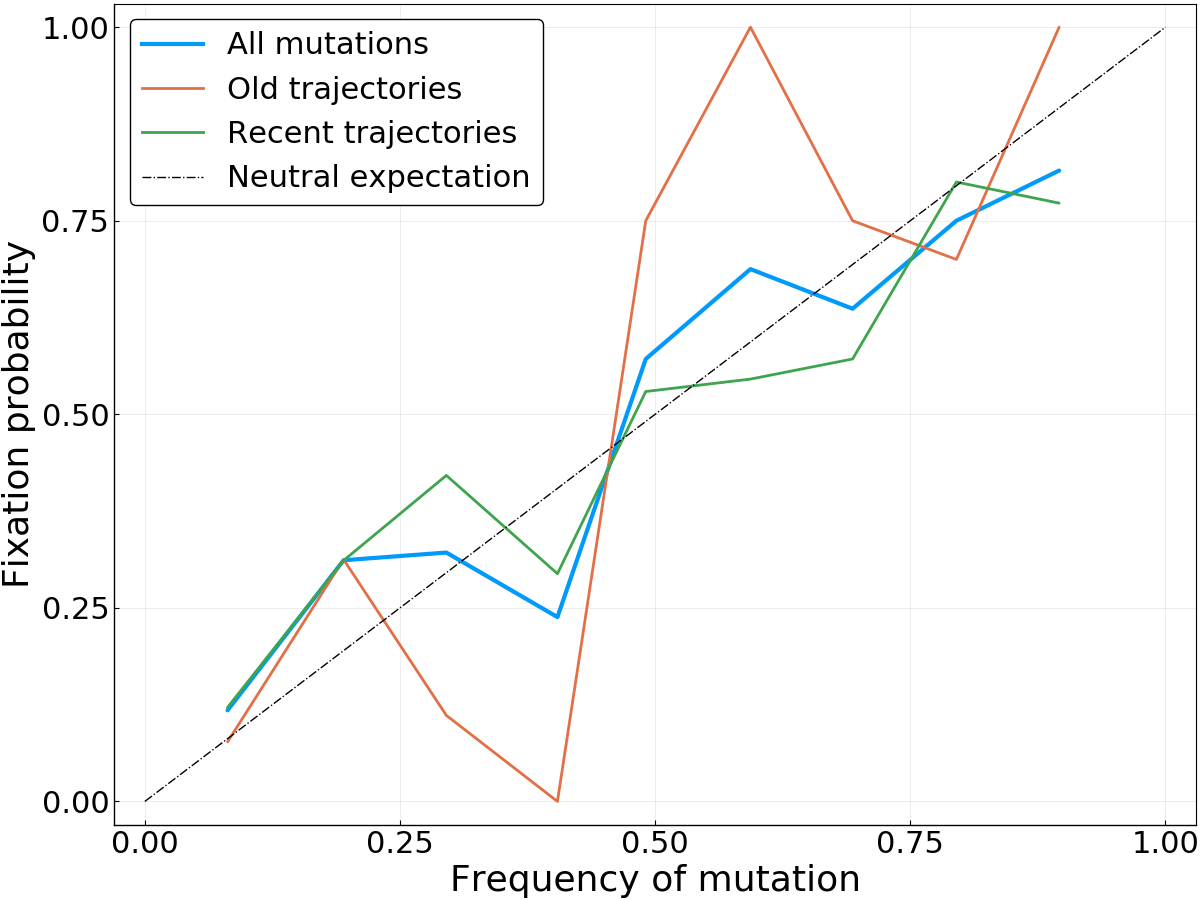

In [67]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat[:,1], dat_high[:,2], label="Old trajectories", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Recent trajectories", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)